# Air Quality Time Series Prediction with ARIMA

This notebook implements **ARIMA (AutoRegressive Integrated Moving Average)** model for time series forecasting of PM 2.5 air quality.

## Key Concepts:
- **ARIMA**: A statistical model for time series forecasting that combines:
  - **AR (AutoRegressive)**: Uses past values to predict future values
  - **I (Integrated)**: Differencing to make the series stationary
  - **MA (Moving Average)**: Uses past forecast errors
- **Time Series Forecasting**: Using historical patterns to predict future PM 2.5 levels


In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
from scipy.stats import jarque_bera
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 1. Load and Explore the Data


In [19]:
# Load the dataset
df = pd.read_csv('Real_Combine.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()


Dataset Shape: (1000, 8)

First few rows:


,T,TM,Tm,H,VV,V,VM,PM 2.5
0,19.9,27.0,12.0,55.0,4.7,8.7,24.1,255.875000
1,21.3,29.0,15.0,45.0,4.5,6.7,14.8,217.083333
2,21.2,29.5,14.0,40.0,4.0,5.4,14.8,229.166667
3,17.3,24.0,11.0,34.0,5.1,11.7,64.4,298.458333
4,18.2,25.0,10.0,43.0,4.8,6.1,14.8,264.916667


In [20]:
# Check for missing values and data info
print("Missing Values:")
print(df.isnull().sum())
print("\nData Info:")
df.info()


Missing Values:
T         0
TM        0
Tm        0
H         0
VV        0
V         0
VM        0
PM 2.5    5
dtype: int64

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1000 non-null   float64
 1   TM      1000 non-null   float64
 2   Tm      1000 non-null   float64
 3   H       1000 non-null   float64
 4   VV      1000 non-null   float64
 5   V       1000 non-null   float64
 6   VM      1000 non-null   float64
 7   PM 2.5  995 non-null    float64
dtypes: float64(8)
memory usage: 62.6 KB


In [21]:
# Handle missing values
df = df.dropna()
print(f"Data shape after dropping missing values: {df.shape}")

# Reset index to ensure proper time series ordering
df = df.reset_index(drop=True)

# Extract PM 2.5 as the time series
ts = df['PM 2.5'].copy()
print(f"\nTime series length: {len(ts)}")
print(f"Time series statistics:")
print(ts.describe())


Data shape after dropping missing values: (995, 8)

Time series length: 995
Time series statistics:
count    995.000000
mean      91.109904
std       90.746817
min        0.000000
25%       26.687800
50%       55.708333
75%      126.291667
max      620.206400
Name: PM 2.5, dtype: float64


## 2. Time Series Visualization


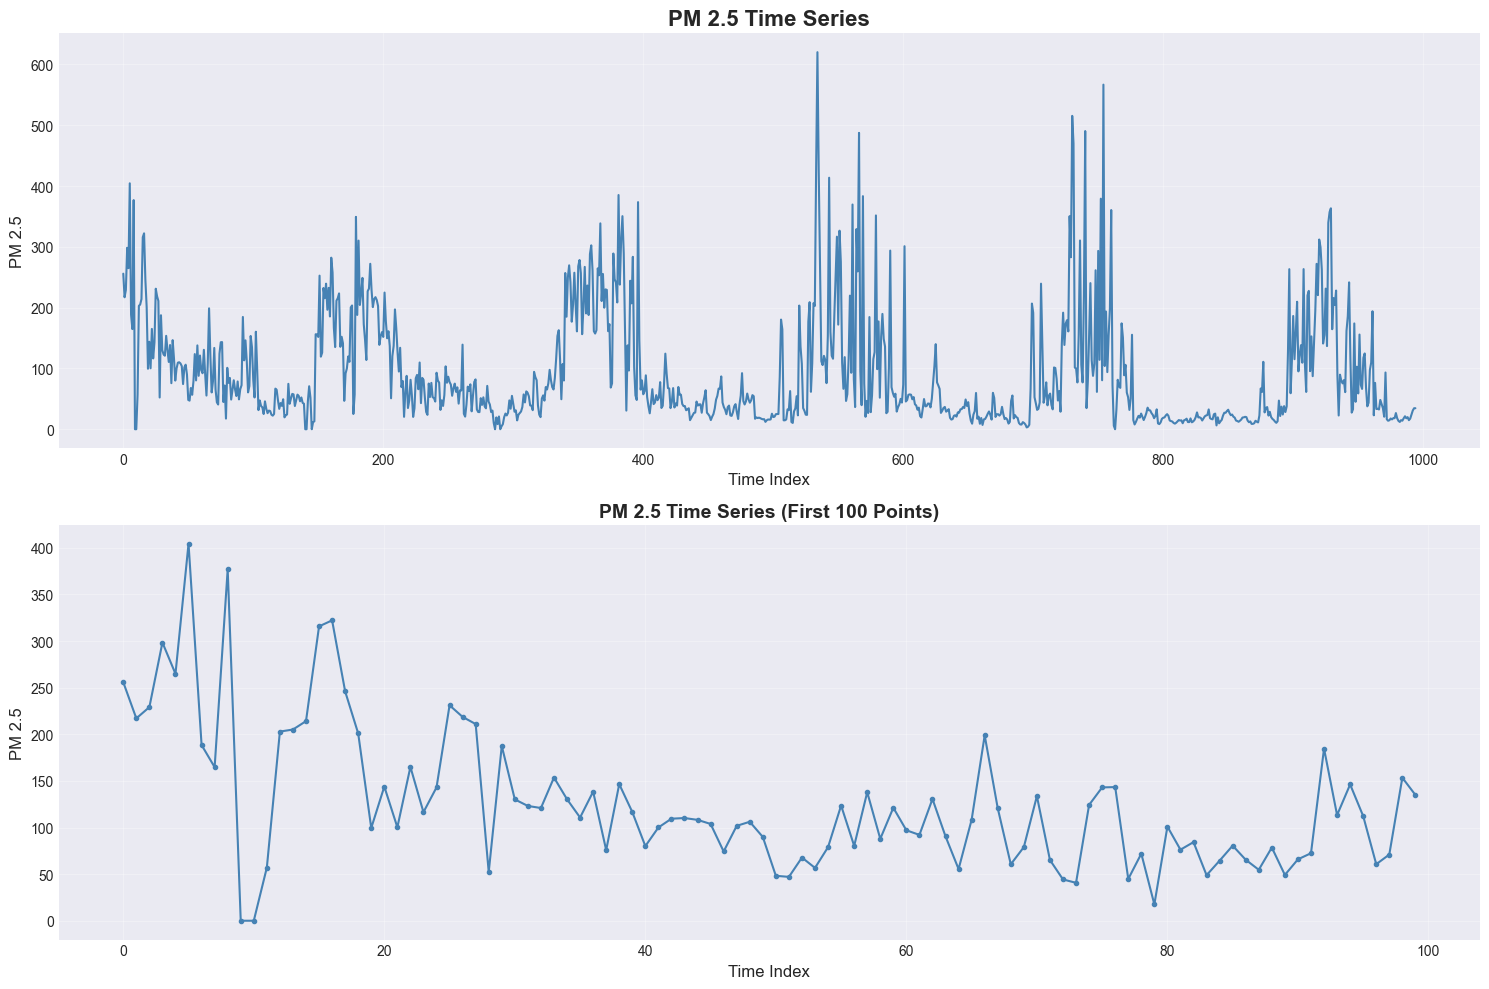

In [22]:
# Visualize the PM 2.5 time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full time series
axes[0].plot(ts.index, ts.values, linewidth=1.5, color='steelblue')
axes[0].set_title('PM 2.5 Time Series', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Time Index', fontsize=12)
axes[0].set_ylabel('PM 2.5', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: First 100 points for detail
axes[1].plot(ts.index[:100], ts.values[:100], linewidth=1.5, color='steelblue', marker='o', markersize=3)
axes[1].set_title('PM 2.5 Time Series (First 100 Points)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Index', fontsize=12)
axes[1].set_ylabel('PM 2.5', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Check Stationarity

ARIMA models require the time series to be **stationary** (constant mean and variance over time). We'll use the Augmented Dickey-Fuller (ADF) test.


In [23]:
def check_stationarity(timeseries, title="Time Series"):
    """
    Check stationarity using Augmented Dickey-Fuller test
    """
    print(f"\n{'='*60}")
    print(f"Stationarity Test: {title}")
    print(f"{'='*60}")
    
    # Perform ADF test
    result = adfuller(timeseries.dropna())
    
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.6f}")
    
    if result[1] <= 0.05:
        print(f"\n✓ Series is STATIONARY (p-value <= 0.05)")
        return True
    else:
        print(f"\n✗ Series is NON-STATIONARY (p-value > 0.05)")
        print("   Need to apply differencing (d > 0 in ARIMA)")
        return False

# Check original series
is_stationary = check_stationarity(ts, "Original PM 2.5 Series")



Stationarity Test: Original PM 2.5 Series
ADF Statistic: -3.905309
p-value: 0.001996
Critical Values:
   1%: -3.437068
   5%: -2.864506
   10%: -2.568349

✓ Series is STATIONARY (p-value <= 0.05)


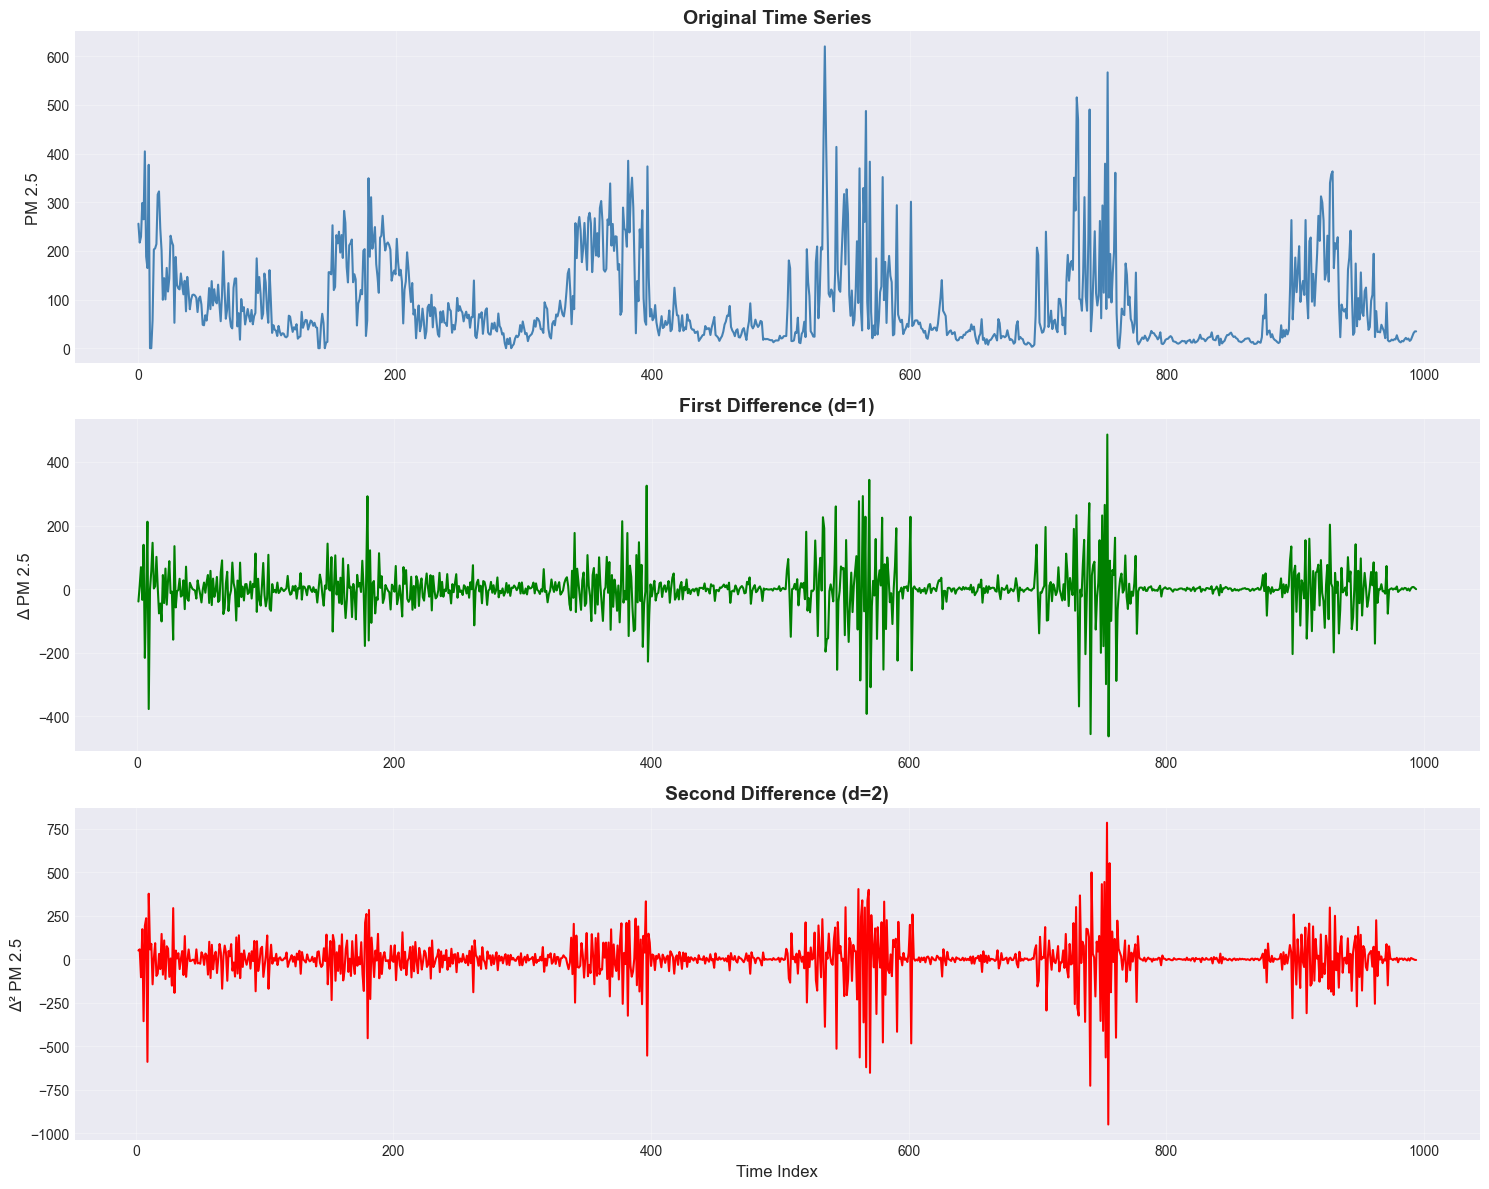

In [24]:
# Visualize original vs differenced series
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Original series
axes[0].plot(ts.index, ts.values, linewidth=1.5, color='steelblue')
axes[0].set_title('Original Time Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('PM 2.5', fontsize=12)
axes[0].grid(True, alpha=0.3)

# First difference
ts_diff1 = ts.diff().dropna()
axes[1].plot(ts_diff1.index, ts_diff1.values, linewidth=1.5, color='green')
axes[1].set_title('First Difference (d=1)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Δ PM 2.5', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Second difference
ts_diff2 = ts_diff1.diff().dropna()
axes[2].plot(ts_diff2.index, ts_diff2.values, linewidth=1.5, color='red')
axes[2].set_title('Second Difference (d=2)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time Index', fontsize=12)
axes[2].set_ylabel('Δ² PM 2.5', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check stationarity of differenced series
if not is_stationary:
    print("\nChecking first difference:")
    is_stationary_diff1 = check_stationarity(ts_diff1, "First Difference")
    
    if not is_stationary_diff1:
        print("\nChecking second difference:")
        check_stationarity(ts_diff2, "Second Difference")


## 4. ACF and PACF Plots

These plots help identify the optimal AR (p) and MA (q) parameters for ARIMA.


Using original series (d=0)


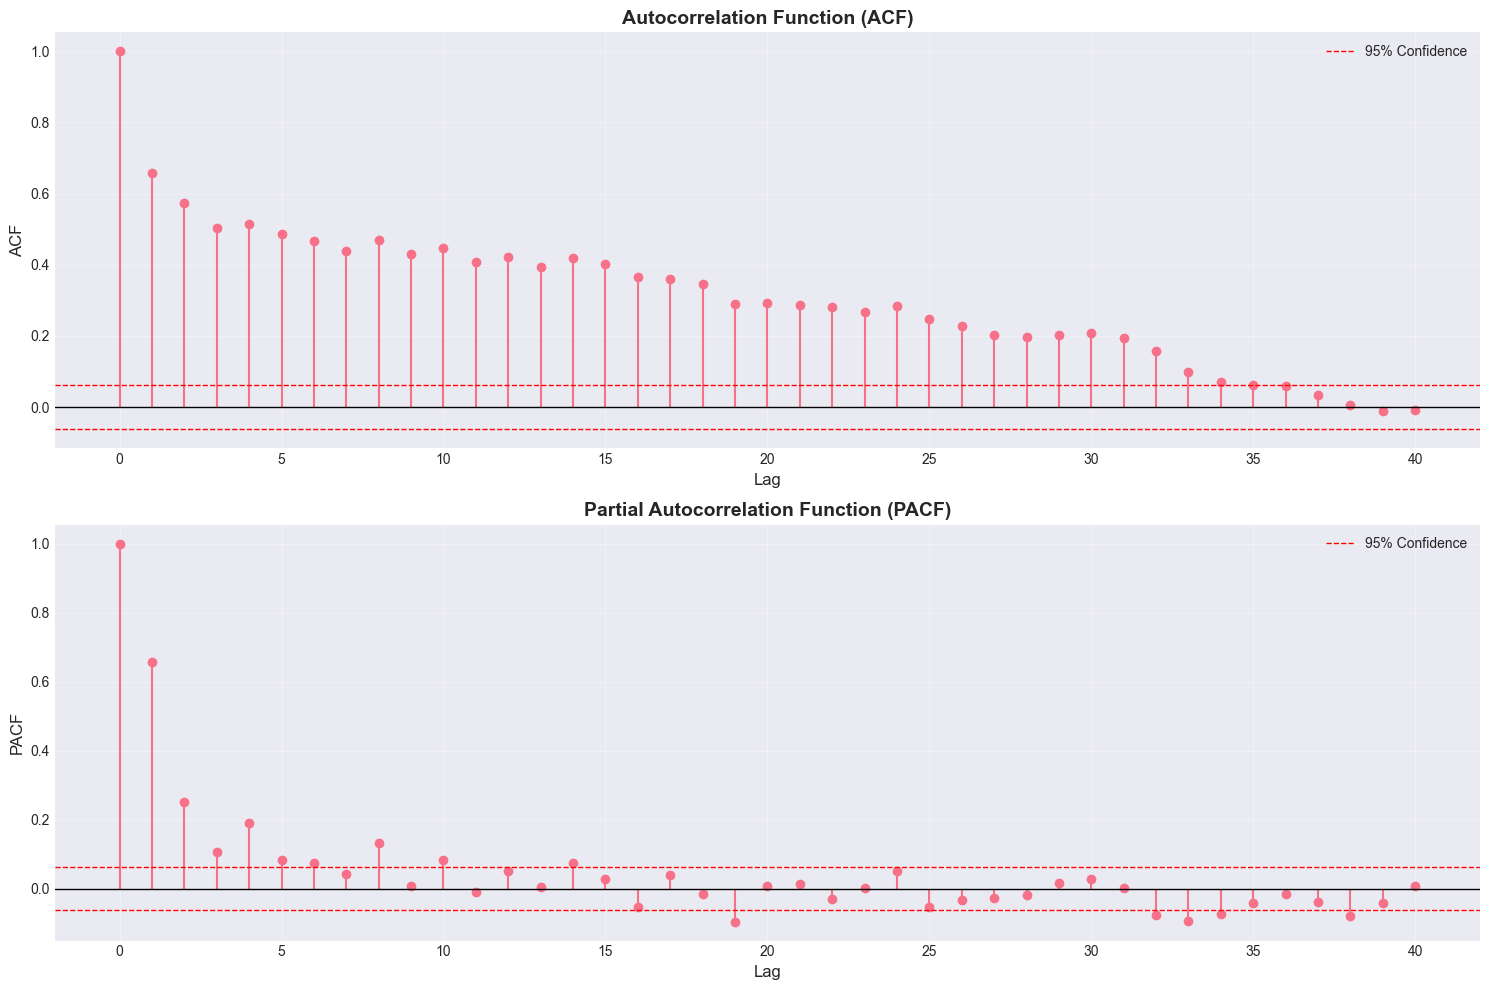


ACF and PACF plots suggest:
- AR order (p): Look for cutoff in PACF
- MA order (q): Look for cutoff in ACF
- Differencing order (d): 0


In [25]:
# Determine differencing order (d)
# Use the differenced series that is stationary
if is_stationary:
    ts_for_arima = ts
    d_order = 0
    print("Using original series (d=0)")
else:
    # Check first difference
    if check_stationarity(ts_diff1, "First Difference"):
        ts_for_arima = ts_diff1
        d_order = 1
        print("\nUsing first difference (d=1)")
    else:
        ts_for_arima = ts_diff2
        d_order = 2
        print("\nUsing second difference (d=2)")

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# ACF (Autocorrelation Function)
acf_values = acf(ts_for_arima.dropna(), nlags=40, fft=True)
axes[0].stem(range(len(acf_values)), acf_values, basefmt=" ")
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].axhline(y=1.96/np.sqrt(len(ts_for_arima)), color='red', linestyle='--', linewidth=1, label='95% Confidence')
axes[0].axhline(y=-1.96/np.sqrt(len(ts_for_arima)), color='red', linestyle='--', linewidth=1)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('ACF', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PACF (Partial Autocorrelation Function)
pacf_values = pacf(ts_for_arima.dropna(), nlags=40, method='ols')
axes[1].stem(range(len(pacf_values)), pacf_values, basefmt=" ")
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(y=1.96/np.sqrt(len(ts_for_arima)), color='red', linestyle='--', linewidth=1, label='95% Confidence')
axes[1].axhline(y=-1.96/np.sqrt(len(ts_for_arima)), color='red', linestyle='--', linewidth=1)
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('PACF', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nACF and PACF plots suggest:")
print(f"- AR order (p): Look for cutoff in PACF")
print(f"- MA order (q): Look for cutoff in ACF")
print(f"- Differencing order (d): {d_order}")


Training set: 796 samples (time steps 0 to 795)
Test set: 199 samples (time steps 796 to 994)

Training period: 0 to 795
Test period: 796 to 994


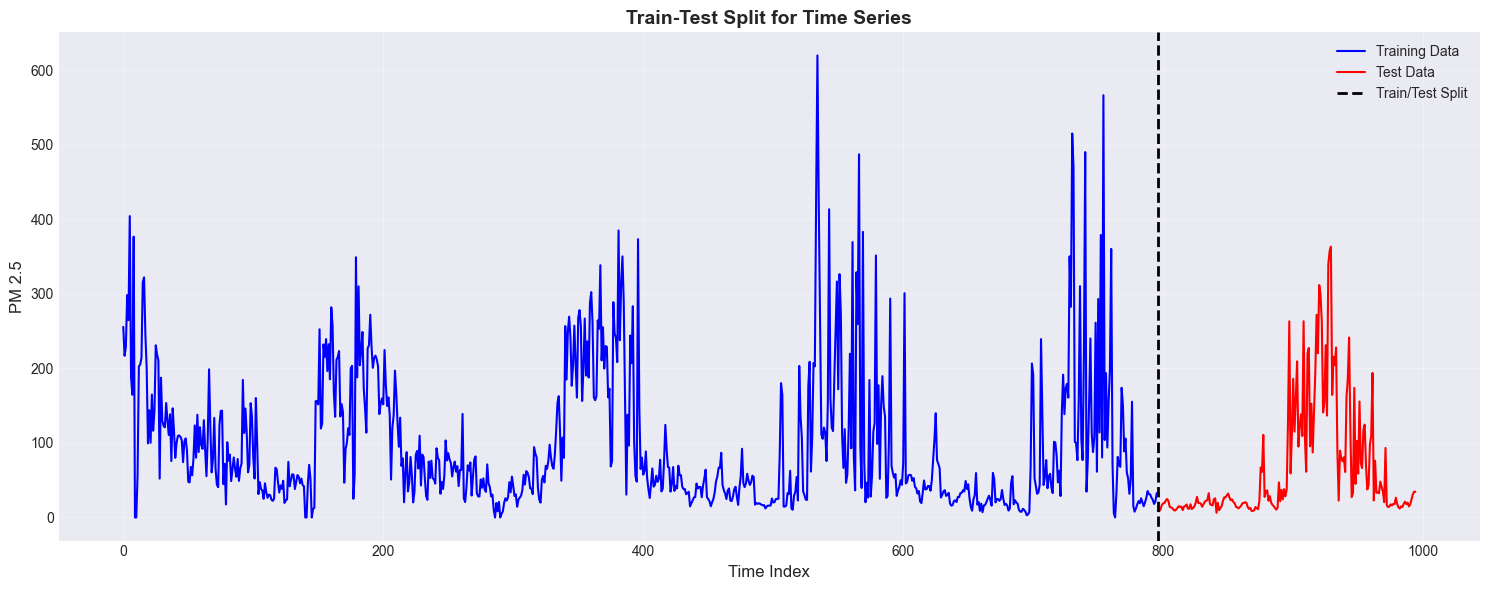

In [26]:
# Time series split: use first 80% for training, last 20% for testing
split_index = int(len(ts) * 0.8)

train_data = ts[:split_index]
test_data = ts[split_index:]

print(f"Training set: {len(train_data)} samples (time steps 0 to {split_index-1})")
print(f"Test set: {len(test_data)} samples (time steps {split_index} to {len(ts)-1})")
print(f"\nTraining period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Test period: {test_data.index[0]} to {test_data.index[-1]}")

# Visualize train-test split
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data.values, label='Training Data', color='blue', linewidth=1.5)
plt.plot(test_data.index, test_data.values, label='Test Data', color='red', linewidth=1.5)
plt.axvline(x=split_index, color='black', linestyle='--', linewidth=2, label='Train/Test Split')
plt.title('Train-Test Split for Time Series', fontsize=14, fontweight='bold')
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('PM 2.5', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Find Optimal ARIMA Parameters

We'll use AIC (Akaike Information Criterion) to find the best (p, d, q) combination.


In [27]:
def find_optimal_arima(train_data, max_p=5, max_d=2, max_q=5):
    """
    Find optimal ARIMA parameters using AIC
    """
    best_aic = np.inf
    best_params = None
    best_model = None
    results = []
    
    print("Searching for optimal ARIMA parameters...")
    print("This may take a few minutes...\n")
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic
                    
                    results.append({
                        'p': p,
                        'd': d,
                        'q': q,
                        'AIC': aic
                    })
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                    
                    print(f"ARIMA({p},{d},{q}) - AIC: {aic:.2f}")
                except:
                    continue
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('AIC')
    
    print(f"\n{'='*60}")
    print("TOP 5 ARIMA MODELS BY AIC:")
    print(f"{'='*60}")
    print(results_df.head().to_string(index=False))
    
    return best_params, best_model, results_df

# Find optimal parameters (using smaller range for faster execution)
optimal_params, optimal_model, results_df = find_optimal_arima(train_data, max_p=3, max_d=2, max_q=3)

print(f"\n{'='*60}")
print(f"OPTIMAL ARIMA PARAMETERS: {optimal_params}")
print(f"Best AIC: {optimal_model.aic:.2f}")
print(f"{'='*60}")


Searching for optimal ARIMA parameters...
This may take a few minutes...

ARIMA(0,0,0) - AIC: 9468.78
ARIMA(0,0,1) - AIC: 9239.02
ARIMA(0,0,2) - AIC: 9120.86
ARIMA(0,0,3) - AIC: 9103.86
ARIMA(0,1,0) - AIC: 9214.43
ARIMA(0,1,1) - AIC: 8994.37
ARIMA(0,1,2) - AIC: 8972.23
ARIMA(0,1,3) - AIC: 8962.76
ARIMA(0,2,0) - AIC: 10011.51
ARIMA(0,2,1) - AIC: 9212.57
ARIMA(0,2,2) - AIC: 8995.03
ARIMA(0,2,3) - AIC: 8973.34
ARIMA(1,0,0) - AIC: 9068.49
ARIMA(1,0,1) - AIC: 8991.73
ARIMA(1,0,2) - AIC: 8977.90
ARIMA(1,0,3) - AIC: 8970.20
ARIMA(1,1,0) - AIC: 9090.50
ARIMA(1,1,1) - AIC: 8966.37
ARIMA(1,1,2) - AIC: 8967.48
ARIMA(1,1,3) - AIC: 8962.57
ARIMA(1,2,0) - AIC: 9604.41
ARIMA(1,2,1) - AIC: 9089.33
ARIMA(1,2,2) - AIC: 8967.62
ARIMA(1,2,3) - AIC: 8996.09
ARIMA(2,0,0) - AIC: 9022.18
ARIMA(2,0,1) - AIC: 8973.40
ARIMA(2,0,2) - AIC: 8974.73
ARIMA(2,0,3) - AIC: 8967.38
ARIMA(2,1,0) - AIC: 9065.33
ARIMA(2,1,1) - AIC: 8966.91
ARIMA(2,1,2) - AIC: 8958.14
ARIMA(2,1,3) - AIC: 8964.33
ARIMA(2,2,0) - AIC: 9486.76
A

## 7. Train ARIMA Model

Using the optimal parameters found above.


In [28]:
# Train the ARIMA model with optimal parameters
# If optimal model wasn't found, use a default
if optimal_model is None:
    print("Using default ARIMA(1,1,1) model")
    model = ARIMA(train_data, order=(1, 1, 1))
    fitted_model = model.fit()
else:
    fitted_model = optimal_model

print("ARIMA Model Summary:")
print("="*60)
print(fitted_model.summary())
print("="*60)


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                 PM 2.5   No. Observations:                  796
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4471.806
Date:                Wed, 19 Nov 2025   AIC                           8957.612
Time:                        22:58:00   BIC                           8990.361
Sample:                             0   HQIC                          8970.196
                                - 796                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4732      0.043    -10.955      0.000      -0.558      -0.389
ar.L2         -0.7008      0.043    -16.187      0.000      -0.786      -0.616
ar.L3          0.1863      0.03

## 8. Make Predictions


In [29]:
# Make in-sample predictions (on training data)
train_pred = fitted_model.predict(start=0, end=len(train_data)-1, typ='levels')

# Make out-of-sample forecasts (on test data)
# For ARIMA, we forecast step-by-step or use forecast() method
forecast_steps = len(test_data)
forecast = fitted_model.forecast(steps=forecast_steps)
forecast_ci = fitted_model.get_forecast(steps=forecast_steps).conf_int()

# Create forecast index
forecast_index = test_data.index

print("Predictions completed!")
print(f"Training predictions: {len(train_pred)} samples")
print(f"Test forecasts: {len(forecast)} samples")
print(f"\nFirst few test forecasts:")
print(forecast.head())


Predictions completed!
Training predictions: 796 samples
Test forecasts: 199 samples

First few test forecasts:
796    35.758390
797    38.746652
798    21.665149
799    28.230611
800    37.651782
Name: predicted_mean, dtype: float64


## 9. Model Evaluation


In [30]:
# Calculate evaluation metrics for training set
train_mae = mean_absolute_error(train_data, train_pred)
train_mse = mean_squared_error(train_data, train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(train_data, train_pred)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(test_data, forecast)
test_mse = mean_squared_error(test_data, forecast)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_data, forecast)

# Display results
print("=" * 60)
print("MODEL EVALUATION METRICS")
print("=" * 60)
print(f"\n{'Metric':<20} {'Training':<20} {'Test':<20}")
print("-" * 60)
print(f"{'R² Score':<20} {train_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'MAE':<20} {train_mae:<20.4f} {test_mae:<20.4f}")
print(f"{'MSE':<20} {train_mse:<20.4f} {test_mse:<20.4f}")
print(f"{'RMSE':<20} {train_rmse:<20.4f} {test_rmse:<20.4f}")
print("=" * 60)


MODEL EVALUATION METRICS

Metric               Training             Test                
------------------------------------------------------------
R² Score             0.4638               -0.1999             
MAE                  41.2918              48.7877             
MSE                  4579.7134            7303.5951           
RMSE                 67.6736              85.4611             


## 9.5. Residual Diagnostic Plots

**Checking the Four Key Assumptions:**

1. **Linearity**: The relationship is linear
2. **Independence**: Residuals are independent (critical for time series)
3. **Homoscedasticity**: Constant variance of residuals
4. **Normality**: Residuals are normally distributed


In [31]:
# Get residuals from the fitted model
train_residuals = fitted_model.resid

# For test set, calculate residuals
test_residuals = test_data.values - forecast.values

# Combine for overall analysis
all_residuals = np.concatenate([train_residuals, test_residuals])
all_fitted = np.concatenate([train_pred.values, forecast.values])
all_order = np.arange(len(all_residuals))

print("Residuals calculated for diagnostic analysis")
print(f"Train residuals: mean={np.mean(train_residuals):.4f}, std={np.std(train_residuals):.4f}")
print(f"Test residuals: mean={np.mean(test_residuals):.4f}, std={np.std(test_residuals):.4f}")


Residuals calculated for diagnostic analysis
Train residuals: mean=-1.0080, std=67.6661
Test residuals: mean=34.7777, std=78.0648


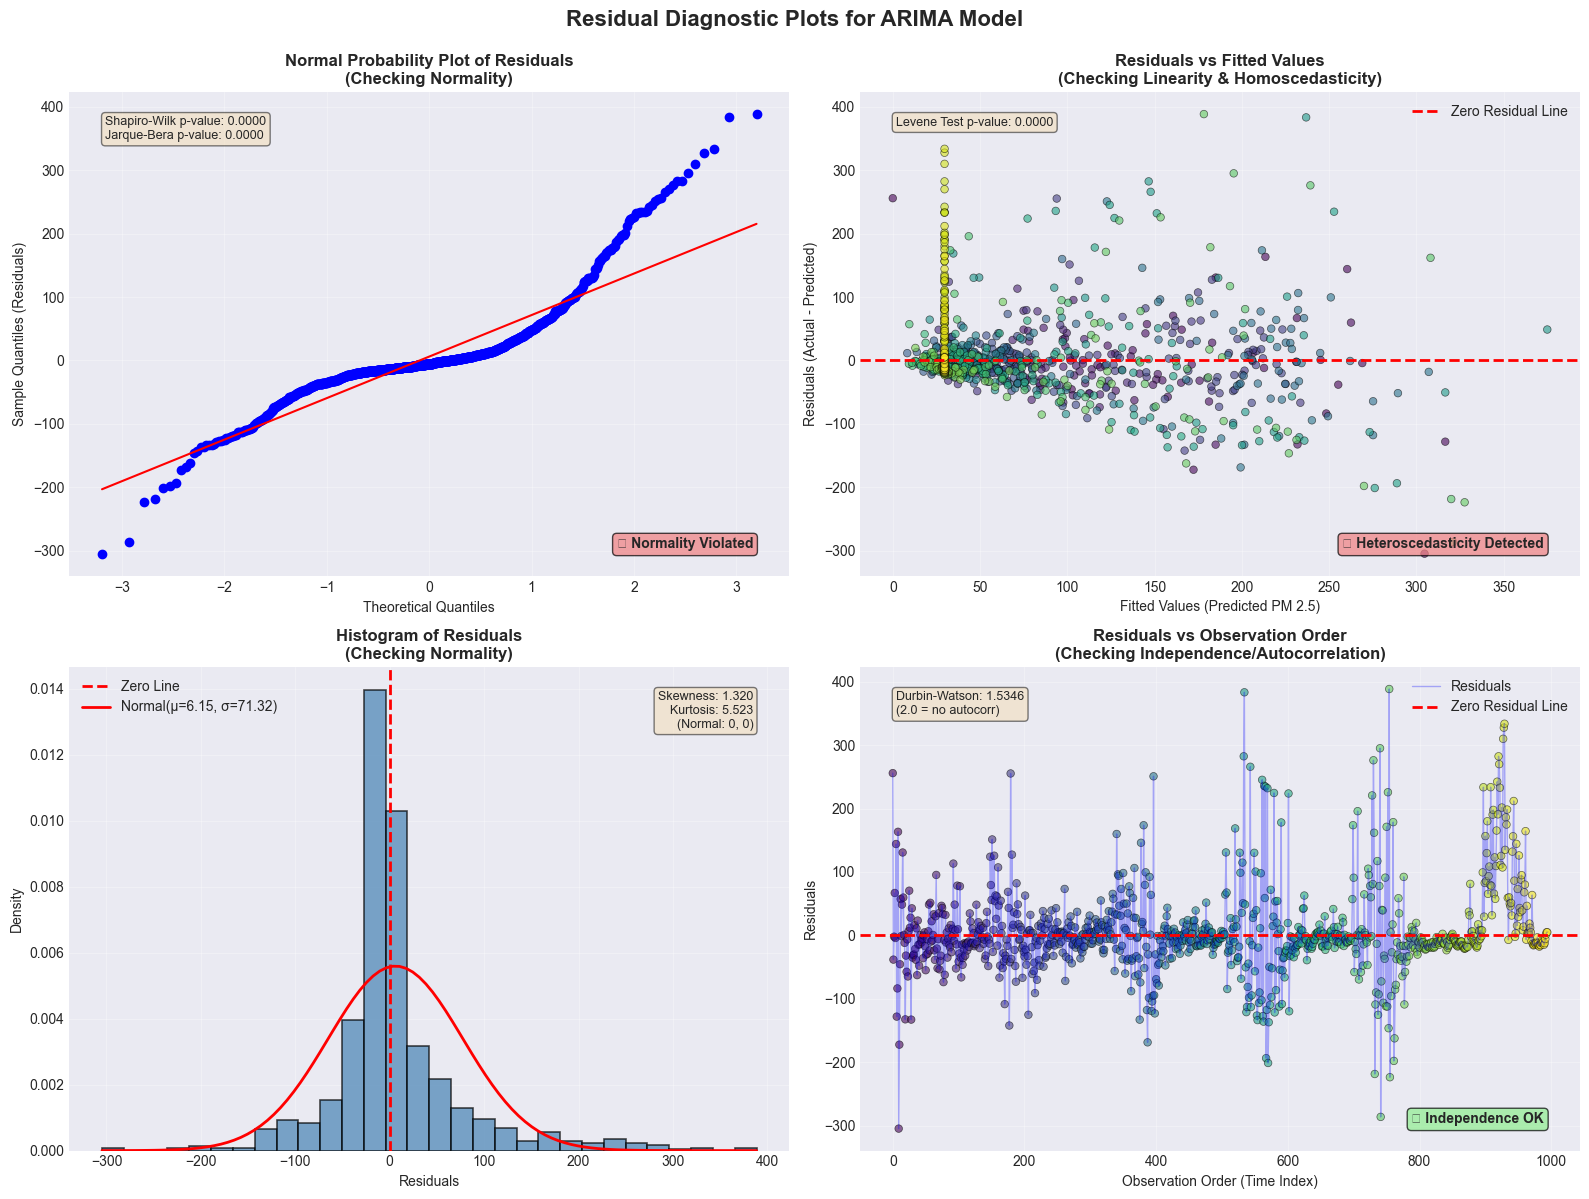


RESIDUAL DIAGNOSTIC SUMMARY

1. NORMALITY:
   - Mean of residuals: 6.1492 (should be ~0)
   - Skewness: 1.3199 (should be ~0 for normality)
   - Kurtosis: 5.5229 (should be ~0 for normality)
   - Shapiro-Wilk p-value: 0.0000 (>0.05 indicates normality)

2. LINEARITY & HOMOSCEDASTICITY:
   - Residuals should be randomly scattered around zero
   - No clear patterns or funnel shapes in residuals vs fitted plot
   - Levene test p-value: 0.0000 (>0.05 indicates constant variance)

3. INDEPENDENCE (Critical for Time Series):
   - Durbin-Watson statistic: 1.5346 (close to 2.0 = no autocorrelation)
   - ✓ No significant autocorrelation detected



In [32]:
# Create comprehensive residual diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Residual Diagnostic Plots for ARIMA Model', 
             fontsize=16, fontweight='bold', y=0.995)

# ============================================
# 1. Normal Probability Plot (Q-Q Plot) - Checking NORMALITY
# ============================================
from scipy.stats import probplot

probplot(all_residuals, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title('Normal Probability Plot of Residuals\n(Checking Normality)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Theoretical Quantiles', fontsize=10)
axes[0, 0].set_ylabel('Sample Quantiles (Residuals)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Perform normality tests
if len(all_residuals) > 0:
    shapiro_stat, shapiro_p = stats.shapiro(all_residuals[:5000]) if len(all_residuals) > 5000 else stats.shapiro(all_residuals)
    jb_stat, jb_p = jarque_bera(all_residuals)
    
    axes[0, 0].text(0.05, 0.95, 
                    f'Shapiro-Wilk p-value: {shapiro_p:.4f}\nJarque-Bera p-value: {jb_p:.4f}',
                    transform=axes[0, 0].transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                    fontsize=9)
    
    if shapiro_p > 0.05:
        axes[0, 0].text(0.95, 0.05, '✓ Normality OK', 
                       transform=axes[0, 0].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                       fontsize=10, fontweight='bold')
    else:
        axes[0, 0].text(0.95, 0.05, '✗ Normality Violated', 
                       transform=axes[0, 0].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
                       fontsize=10, fontweight='bold')

# ============================================
# 2. Residuals vs Fitted Values - Checking LINEARITY & HOMOSCEDASTICITY
# ============================================
scatter1 = axes[0, 1].scatter(all_fitted, all_residuals, alpha=0.6, s=30, c=all_order, 
                              cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')
axes[0, 1].set_title('Residuals vs Fitted Values\n(Checking Linearity & Homoscedasticity)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fitted Values (Predicted PM 2.5)', fontsize=10)
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)', fontsize=10)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Levene's test for equal variances
try:
    n_regions = 5
    fitted_sorted_idx = np.argsort(all_fitted)
    region_size = len(all_fitted) // n_regions
    region_groups = []
    for i in range(n_regions):
        start_idx = i * region_size
        end_idx = (i + 1) * region_size if i < n_regions - 1 else len(all_fitted)
        region_groups.append(all_residuals[fitted_sorted_idx[start_idx:end_idx]])
    
    levene_stat, levene_p = stats.levene(*region_groups)
    axes[0, 1].text(0.05, 0.95, 
                   f'Levene Test p-value: {levene_p:.4f}',
                   transform=axes[0, 1].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=9)
    
    if levene_p > 0.05:
        axes[0, 1].text(0.95, 0.05, '✓ Homoscedasticity OK', 
                       transform=axes[0, 1].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                       fontsize=10, fontweight='bold')
    else:
        axes[0, 1].text(0.95, 0.05, '✗ Heteroscedasticity Detected', 
                       transform=axes[0, 1].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
                       fontsize=10, fontweight='bold')
except:
    levene_p = None

# ============================================
# 3. Histogram of Residuals - Checking NORMALITY
# ============================================
n, bins, patches = axes[1, 0].hist(all_residuals, bins=30, edgecolor='black', 
                                   linewidth=1.2, alpha=0.7, color='steelblue', density=True)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Line')

# Overlay normal distribution
mu, sigma = np.mean(all_residuals), np.std(all_residuals)
x_norm = np.linspace(all_residuals.min(), all_residuals.max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)
axes[1, 0].plot(x_norm, y_norm, 'r-', linewidth=2, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
axes[1, 0].set_title('Histogram of Residuals\n(Checking Normality)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Residuals', fontsize=10)
axes[1, 0].set_ylabel('Density', fontsize=10)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add skewness and kurtosis
skewness = stats.skew(all_residuals)
kurtosis = stats.kurtosis(all_residuals)
axes[1, 0].text(0.95, 0.95, 
               f'Skewness: {skewness:.3f}\nKurtosis: {kurtosis:.3f}\n(Normal: 0, 0)',
               transform=axes[1, 0].transAxes,
               verticalalignment='top',
               horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               fontsize=9)

# ============================================
# 4. Residuals vs Order - Checking INDEPENDENCE (Critical for Time Series!)
# ============================================
axes[1, 1].scatter(all_order, all_residuals, alpha=0.6, s=30, c=all_order, 
                  cmap='viridis', edgecolors='black', linewidth=0.5)
axes[1, 1].plot(all_order, all_residuals, 'b-', alpha=0.3, linewidth=1, label='Residuals')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')
axes[1, 1].set_title('Residuals vs Observation Order\n(Checking Independence/Autocorrelation)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Observation Order (Time Index)', fontsize=10)
axes[1, 1].set_ylabel('Residuals', fontsize=10)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Test for autocorrelation (Durbin-Watson test)
try:
    dw_stat = durbin_watson(all_residuals)
    axes[1, 1].text(0.05, 0.95, 
                   f'Durbin-Watson: {dw_stat:.4f}\n(2.0 = no autocorr)',
                   transform=axes[1, 1].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=9)
    
    # Durbin-Watson interpretation: close to 2 = no autocorrelation
    if 1.5 < dw_stat < 2.5:
        axes[1, 1].text(0.95, 0.05, '✓ Independence OK', 
                       transform=axes[1, 1].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
                       fontsize=10, fontweight='bold')
    else:
        axes[1, 1].text(0.95, 0.05, '✗ Autocorrelation Detected', 
                       transform=axes[1, 1].transAxes,
                       verticalalignment='bottom',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
                       fontsize=10, fontweight='bold')
except ImportError:
    dw_stat = None
    # Alternative: Ljung-Box test
    try:
        lb_stat, lb_p = acorr_ljungbox(all_residuals, lags=10, return_df=False)
        axes[1, 1].text(0.05, 0.95, 
                       f'Ljung-Box p-value: {lb_p[-1]:.4f}',
                       transform=axes[1, 1].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                       fontsize=9)
    except:
        autocorr = np.corrcoef(all_residuals[:-1], all_residuals[1:])[0, 1]
        axes[1, 1].text(0.05, 0.95, 
                       f'Lag-1 Autocorr: {autocorr:.4f}',
                       transform=axes[1, 1].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                       fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("RESIDUAL DIAGNOSTIC SUMMARY")
print("="*70)
print("\n1. NORMALITY:")
print(f"   - Mean of residuals: {np.mean(all_residuals):.4f} (should be ~0)")
print(f"   - Skewness: {skewness:.4f} (should be ~0 for normality)")
print(f"   - Kurtosis: {kurtosis:.4f} (should be ~0 for normality)")
print(f"   - Shapiro-Wilk p-value: {shapiro_p:.4f} (>0.05 indicates normality)")

print("\n2. LINEARITY & HOMOSCEDASTICITY:")
print(f"   - Residuals should be randomly scattered around zero")
print(f"   - No clear patterns or funnel shapes in residuals vs fitted plot")
if levene_p is not None:
    print(f"   - Levene test p-value: {levene_p:.4f} (>0.05 indicates constant variance)")
else:
    print("   - Levene test p-value: N/A (test not performed)")

print("\n3. INDEPENDENCE (Critical for Time Series):")
if dw_stat is not None:
    print(f"   - Durbin-Watson statistic: {dw_stat:.4f} (close to 2.0 = no autocorrelation)")
    if 1.5 < dw_stat < 2.5:
        print("   - ✓ No significant autocorrelation detected")
    else:
        print("   - ✗ Autocorrelation detected - model may not capture temporal dependencies")
else:
    print("   - Check the residuals vs order plot for patterns")

print("\n" + "="*70)


## 10. Visualize Predictions


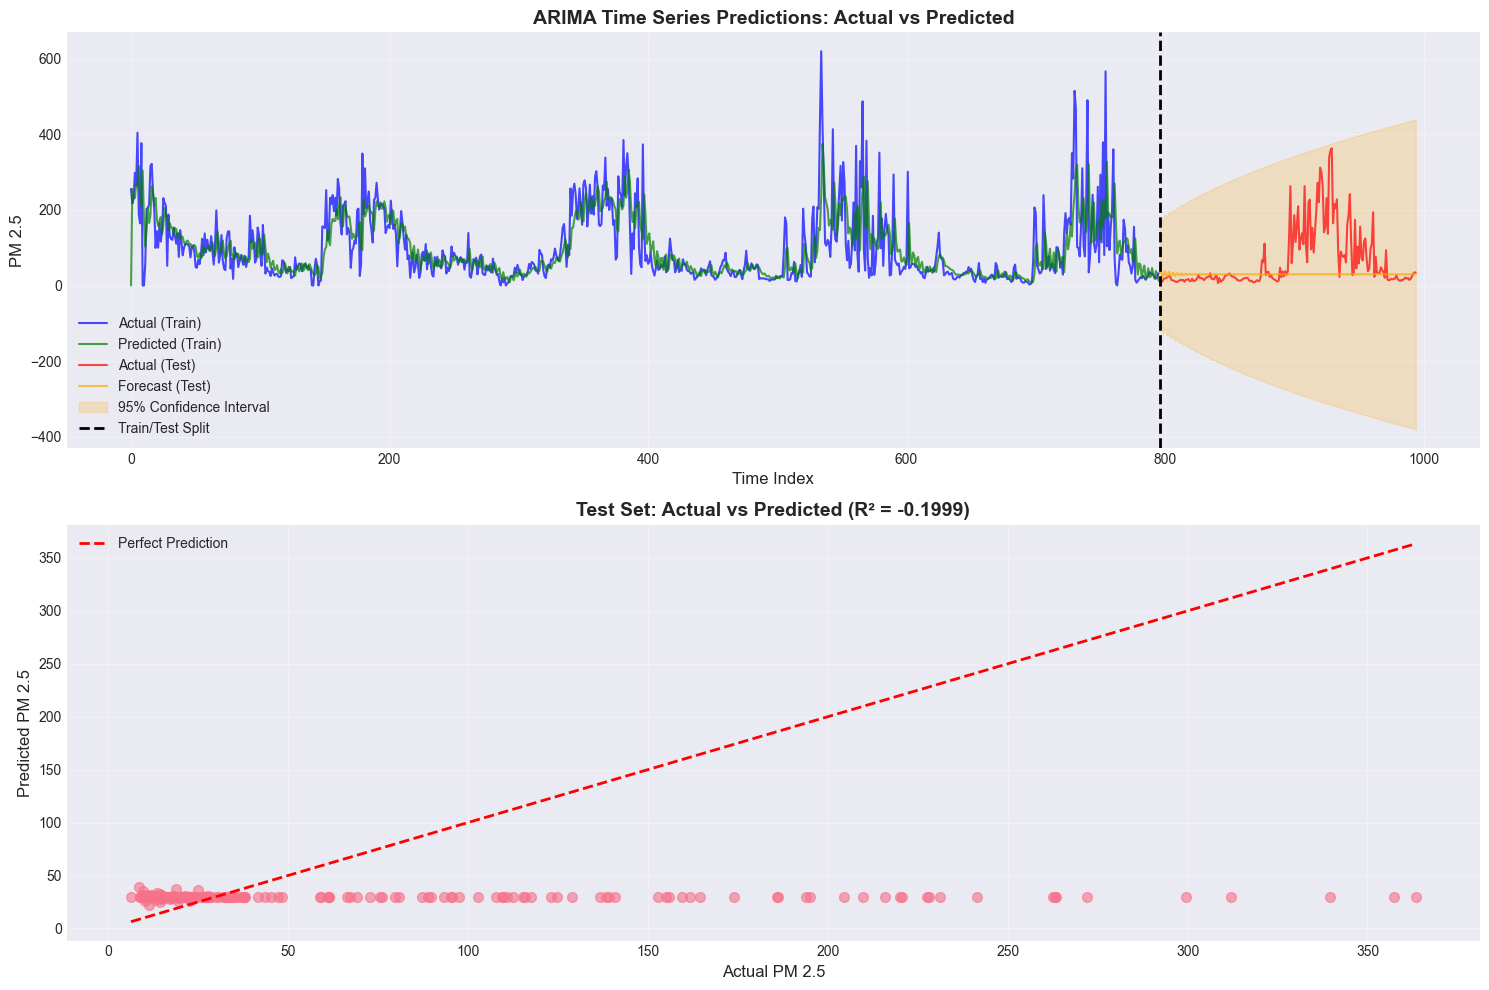

In [33]:
# Plot predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full time series with predictions
axes[0].plot(train_data.index, train_data.values, label='Actual (Train)', color='blue', alpha=0.7, linewidth=1.5)
axes[0].plot(train_data.index, train_pred.values, label='Predicted (Train)', color='green', alpha=0.7, linewidth=1.5)
axes[0].plot(test_data.index, test_data.values, label='Actual (Test)', color='red', alpha=0.7, linewidth=1.5)
axes[0].plot(forecast_index, forecast.values, label='Forecast (Test)', color='orange', alpha=0.7, linewidth=1.5)
axes[0].fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                     color='orange', alpha=0.2, label='95% Confidence Interval')
axes[0].axvline(x=split_index, color='black', linestyle='--', linewidth=2, label='Train/Test Split')
axes[0].set_title('ARIMA Time Series Predictions: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Index', fontsize=12)
axes[0].set_ylabel('PM 2.5', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot for test set
axes[1].scatter(test_data.values, forecast.values, alpha=0.6, s=50)
axes[1].plot([test_data.min(), test_data.max()], [test_data.min(), test_data.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual PM 2.5', fontsize=12)
axes[1].set_ylabel('Predicted PM 2.5', fontsize=12)
axes[1].set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Compare Different ARIMA Models

Let's test a few common ARIMA configurations to compare performance.


In [34]:
# Test different ARIMA models
arima_configs = [
    (1, 1, 1),  # Standard ARIMA
    (2, 1, 2),  # Higher order
    (0, 1, 1),  # MA only
    (1, 1, 0),  # AR only
    (1, 0, 1),  # ARMA (no differencing)
]

results = []

for p, d, q in arima_configs:
    try:
        # Train model
        model = ARIMA(train_data, order=(p, d, q))
        fitted = model.fit()
        
        # Forecast
        forecast_test = fitted.forecast(steps=len(test_data))
        
        # Calculate metrics
        test_mae = mean_absolute_error(test_data, forecast_test)
        test_rmse = np.sqrt(mean_squared_error(test_data, forecast_test))
        test_r2 = r2_score(test_data, forecast_test)
        
        results.append({
            'ARIMA(p,d,q)': f'({p},{d},{q})',
            'AIC': fitted.aic,
            'Test R²': test_r2,
            'Test MAE': test_mae,
            'Test RMSE': test_rmse
        })
        
        print(f"ARIMA({p},{d},{q}): AIC={fitted.aic:.2f}, Test R²={test_r2:.4f}, Test RMSE={test_rmse:.4f}")
    except Exception as e:
        print(f"ARIMA({p},{d},{q}): Failed - {str(e)}")

results_df = pd.DataFrame(results)
if len(results_df) > 0:
    print("\n" + "=" * 60)
    print("ARIMA MODELS COMPARISON")
    print("=" * 60)
    print(results_df.to_string(index=False))
    
    # Find best model
    best_model_idx = results_df['Test R²'].idxmax()
    best_model = results_df.loc[best_model_idx]
    print(f"\nBest Model: ARIMA{best_model['ARIMA(p,d,q)']}")
    print(f"Test R²: {best_model['Test R²']:.4f}")
    print(f"Test RMSE: {best_model['Test RMSE']:.4f}")


ARIMA(1,1,1): AIC=8966.37, Test R²=-0.2140, Test RMSE=85.9615
ARIMA(2,1,2): AIC=8958.14, Test R²=-0.2032, Test RMSE=85.5796
ARIMA(0,1,1): AIC=8994.37, Test R²=-0.2410, Test RMSE=86.9148
ARIMA(1,1,0): AIC=9090.50, Test R²=-0.1994, Test RMSE=85.4441
ARIMA(1,0,1): AIC=8991.73, Test R²=-0.0800, Test RMSE=81.0798

ARIMA MODELS COMPARISON
ARIMA(p,d,q)         AIC   Test R²  Test MAE  Test RMSE
     (1,1,1) 8966.371300 -0.213961 48.595273  85.961474
     (2,1,2) 8958.138048 -0.203199 48.718057  85.579594
     (0,1,1) 8994.366402 -0.241035 48.420475  86.914757
     (1,1,0) 9090.496719 -0.199391 48.737331  85.444058
     (1,0,1) 8991.734973 -0.079997 70.353922  81.079824

Best Model: ARIMA(1,0,1)
Test R²: -0.0800
Test RMSE: 81.0798


## 13. ARIMA with Sliding Windows for Forecasting

**Rolling Window Forecasting Approach:**
- Use a sliding window of past data
- Fit ARIMA on each window
- Forecast the next step(s)
- Slide the window forward and repeat

This approach adapts to recent patterns and can improve forecast accuracy.


In [35]:
def rolling_window_arima_forecast(train_data, test_data, window_size, arima_order, forecast_horizon=1):
    """
    Perform rolling window ARIMA forecasting
    
    Parameters:
    -----------
    train_data : Series
        Training time series data
    test_data : Series
        Test time series data (to forecast)
    window_size : int
        Size of the sliding window
    arima_order : tuple
        ARIMA order (p, d, q)
    forecast_horizon : int
        Number of steps ahead to forecast (default=1)
    
    Returns:
    --------
    forecasts : array
        Forecasted values
    actuals : array
        Actual values (for comparison)
    """
    forecasts = []
    actuals = []
    all_data = pd.concat([train_data, test_data])
    
    # Start from the end of training data
    start_idx = len(train_data)
    end_idx = len(all_data)
    
    print(f"Rolling window ARIMA forecasting:")
    print(f"  Window size: {window_size}")
    print(f"  ARIMA order: {arima_order}")
    print(f"  Forecast horizon: {forecast_horizon}")
    print(f"  Total test points: {len(test_data)}\n")
    
    for i in range(start_idx, end_idx, forecast_horizon):
        # Get the window of data
        window_start = max(0, i - window_size)
        window_data = all_data[window_start:i]
        
        try:
            # Fit ARIMA on the window
            model = ARIMA(window_data, order=arima_order)
            fitted_model = model.fit()
            
            # Forecast next step(s)
            forecast = fitted_model.forecast(steps=forecast_horizon)
            
            # Store forecast and actual
            if forecast_horizon == 1:
                forecasts.append(forecast.iloc[0] if hasattr(forecast, 'iloc') else forecast[0])
                actuals.append(all_data.iloc[i] if i < len(all_data) else np.nan)
            else:
                # For multi-step, take the first forecast
                forecasts.append(forecast.iloc[0] if hasattr(forecast, 'iloc') else forecast[0])
                actuals.append(all_data.iloc[i] if i < len(all_data) else np.nan)
            
            if (i - start_idx) % 20 == 0:
                print(f"  Processed {i - start_idx + 1}/{len(test_data)} points...")
        except Exception as e:
            # If model fails, use last known value or mean
            if len(forecasts) > 0:
                forecasts.append(forecasts[-1])
            else:
                forecasts.append(window_data.mean())
            actuals.append(all_data.iloc[i] if i < len(all_data) else np.nan)
    
    return np.array(forecasts), np.array(actuals)

# Set parameters for sliding window forecasting
window_size_arima = 100  # Use last 100 points for each forecast
arima_order_sw = optimal_params if optimal_params else (1, 1, 1)  # Use optimal order found earlier

print("="*60)
print("SLIDING WINDOW ARIMA FORECASTING")
print("="*60)

# Perform rolling window forecasting
forecasts_sw, actuals_sw = rolling_window_arima_forecast(
    train_data, 
    test_data, 
    window_size=window_size_arima,
    arima_order=arima_order_sw,
    forecast_horizon=1
)

print(f"\nForecasting completed!")
print(f"Number of forecasts: {len(forecasts_sw)}")
print(f"Number of actuals: {len(actuals_sw)}")


SLIDING WINDOW ARIMA FORECASTING
Rolling window ARIMA forecasting:
  Window size: 100
  ARIMA order: (3, 1, 3)
  Forecast horizon: 1
  Total test points: 199

  Processed 1/199 points...
  Processed 21/199 points...
  Processed 41/199 points...
  Processed 61/199 points...
  Processed 81/199 points...
  Processed 101/199 points...
  Processed 121/199 points...
  Processed 141/199 points...
  Processed 161/199 points...
  Processed 181/199 points...

Forecasting completed!
Number of forecasts: 199
Number of actuals: 199


In [36]:
# Evaluate sliding window ARIMA forecasts
sw_mae = mean_absolute_error(actuals_sw, forecasts_sw)
sw_mse = mean_squared_error(actuals_sw, forecasts_sw)
sw_rmse = np.sqrt(sw_mse)
sw_r2 = r2_score(actuals_sw, forecasts_sw)

print("=" * 60)
print("SLIDING WINDOW ARIMA EVALUATION METRICS")
print("=" * 60)
print(f"R² Score:  {sw_r2:.4f}")
print(f"MAE:       {sw_mae:.4f}")
print(f"MSE:       {sw_mse:.4f}")
print(f"RMSE:      {sw_rmse:.4f}")
print("=" * 60)

# Compare with standard ARIMA
print("\n" + "=" * 60)
print("COMPARISON: Standard ARIMA vs Sliding Window ARIMA")
print("=" * 60)
print(f"{'Metric':<20} {'Standard ARIMA':<20} {'Sliding Window ARIMA':<20}")
print("-" * 60)
print(f"{'R² Score':<20} {test_r2:<20.4f} {sw_r2:<20.4f}")
print(f"{'MAE':<20} {test_mae:<20.4f} {sw_mae:<20.4f}")
print(f"{'RMSE':<20} {test_rmse:<20.4f} {sw_rmse:<20.4f}")
print("=" * 60)


SLIDING WINDOW ARIMA EVALUATION METRICS
R² Score:  0.3459
MAE:       32.9501
MSE:       3981.3600
RMSE:      63.0980

COMPARISON: Standard ARIMA vs Sliding Window ARIMA
Metric               Standard ARIMA       Sliding Window ARIMA
------------------------------------------------------------
R² Score             -0.0800              0.3459              
MAE                  70.3539              32.9501             
RMSE                 81.0798              63.0980             


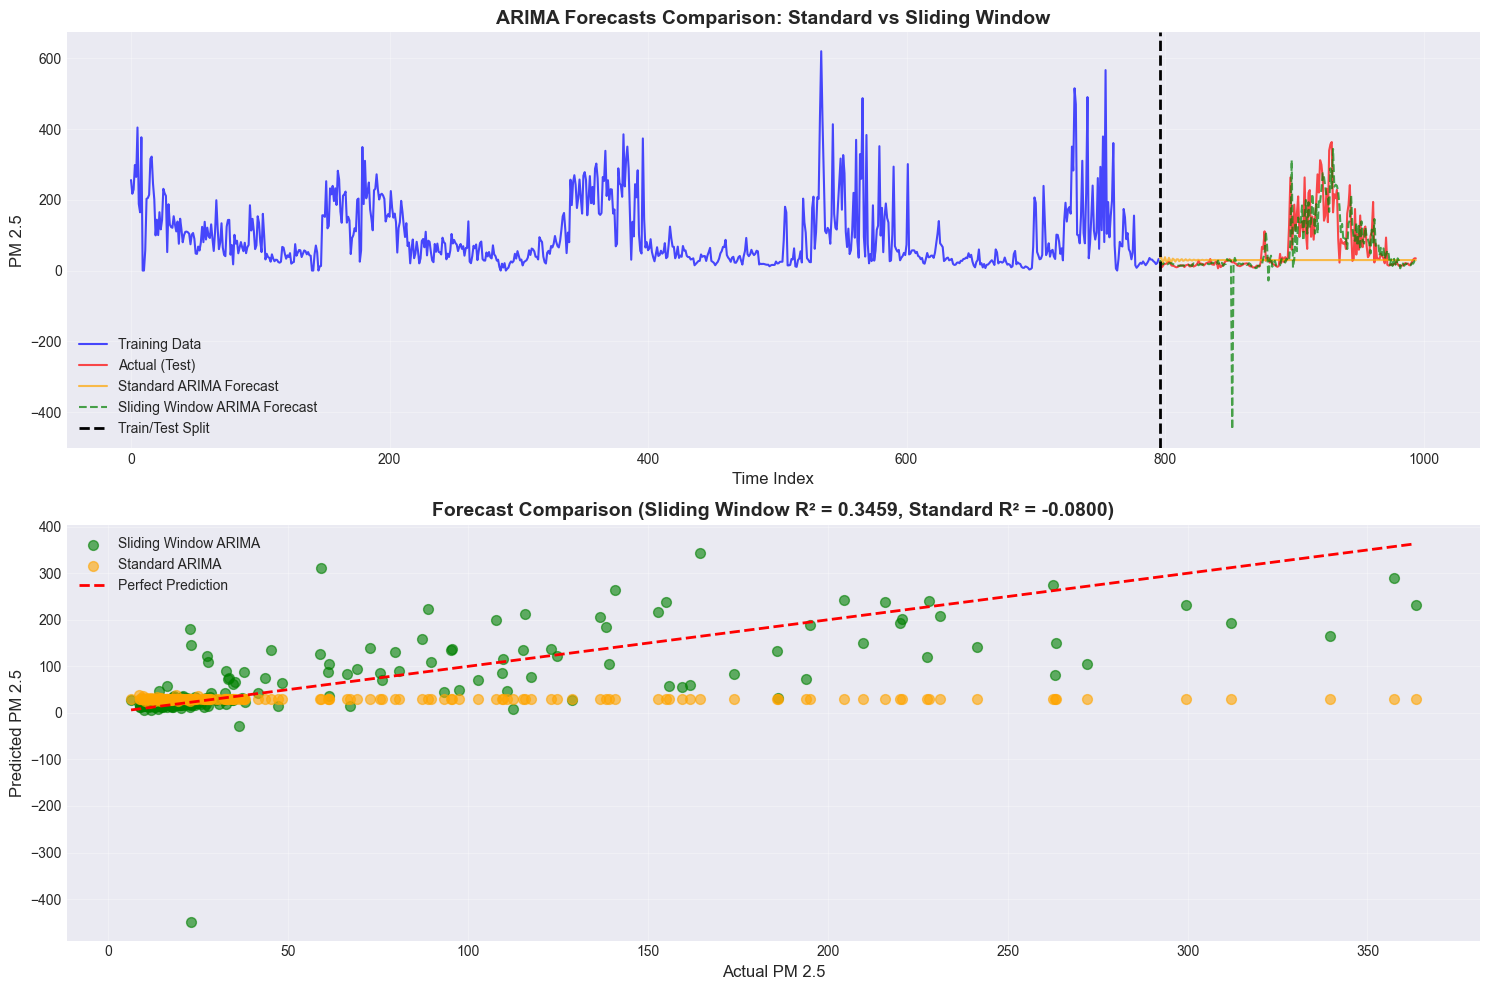

In [37]:
# Visualize sliding window forecasts
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full comparison
axes[0].plot(train_data.index, train_data.values, label='Training Data', color='blue', alpha=0.7, linewidth=1.5)
axes[0].plot(test_data.index, test_data.values, label='Actual (Test)', color='red', alpha=0.7, linewidth=1.5)
axes[0].plot(test_data.index, forecast.values, label='Standard ARIMA Forecast', color='orange', alpha=0.7, linewidth=1.5)
axes[0].plot(test_data.index[:len(forecasts_sw)], forecasts_sw, label='Sliding Window ARIMA Forecast', 
             color='green', alpha=0.7, linewidth=1.5, linestyle='--')
axes[0].axvline(x=split_index, color='black', linestyle='--', linewidth=2, label='Train/Test Split')
axes[0].set_title('ARIMA Forecasts Comparison: Standard vs Sliding Window', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Index', fontsize=12)
axes[0].set_ylabel('PM 2.5', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot for sliding window forecasts
axes[1].scatter(actuals_sw, forecasts_sw, alpha=0.6, s=50, color='green', label='Sliding Window ARIMA')
axes[1].scatter(test_data.values, forecast.values, alpha=0.6, s=50, color='orange', label='Standard ARIMA')
axes[1].plot([test_data.min(), test_data.max()], [test_data.min(), test_data.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual PM 2.5', fontsize=12)
axes[1].set_ylabel('Predicted PM 2.5', fontsize=12)
axes[1].set_title(f'Forecast Comparison (Sliding Window R² = {sw_r2:.4f}, Standard R² = {test_r2:.4f})', 
                 fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 14. Experiment with Different Window Sizes

Let's test different sliding window sizes to find the optimal one.


Rolling window ARIMA forecasting:
  Window size: 50
  ARIMA order: (3, 1, 3)
  Forecast horizon: 1
  Total test points: 199

  Processed 1/199 points...
  Processed 21/199 points...
  Processed 41/199 points...
  Processed 61/199 points...
  Processed 81/199 points...
  Processed 101/199 points...
  Processed 121/199 points...
  Processed 141/199 points...
  Processed 161/199 points...
  Processed 181/199 points...
Window Size  50: R² = 0.5044, RMSE = 54.9274
Rolling window ARIMA forecasting:
  Window size: 100
  ARIMA order: (3, 1, 3)
  Forecast horizon: 1
  Total test points: 199

  Processed 1/199 points...
  Processed 21/199 points...
  Processed 41/199 points...
  Processed 61/199 points...
  Processed 81/199 points...
  Processed 101/199 points...
  Processed 121/199 points...
  Processed 141/199 points...
  Processed 161/199 points...
  Processed 181/199 points...
Window Size 100: R² = 0.3459, RMSE = 63.0980
Rolling window ARIMA forecasting:
  Window size: 150
  ARIMA order: (3,

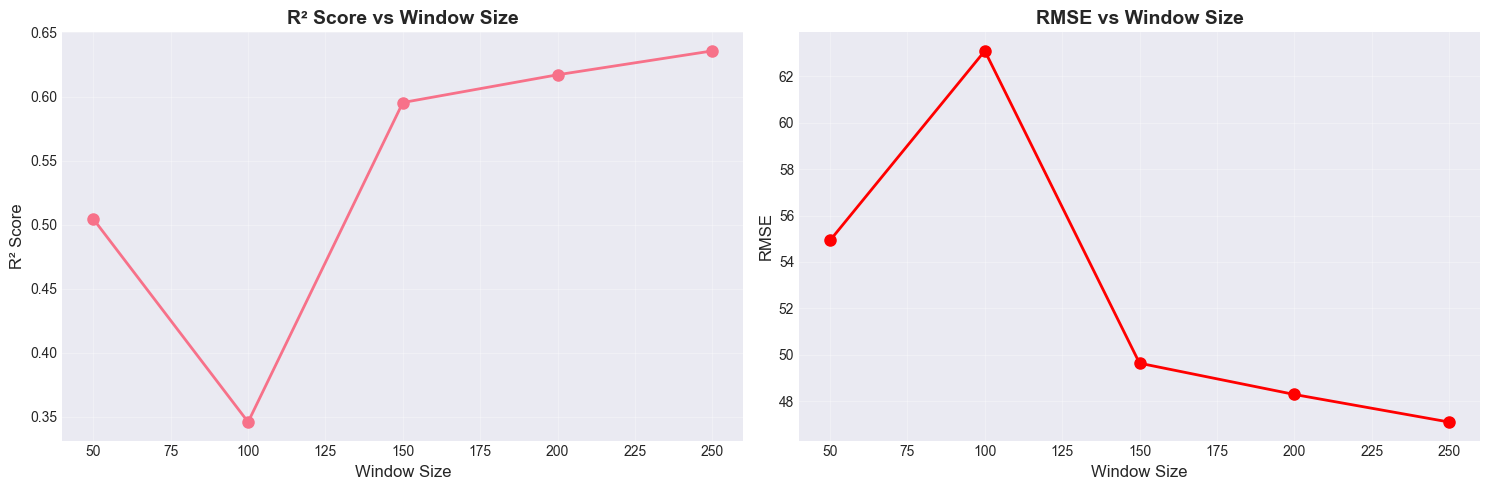


Best Window Size: 250
Best R²: 0.6356
Best RMSE: 47.0953


In [38]:
# Test different window sizes
window_sizes = [50, 100, 150, 200, 250]
sw_results = []

for ws in window_sizes:
    try:
        # Perform rolling window forecasting
        forecasts_ws, actuals_ws = rolling_window_arima_forecast(
            train_data, 
            test_data, 
            window_size=ws,
            arima_order=arima_order_sw,
            forecast_horizon=1
        )
        
        # Calculate metrics
        ws_mae = mean_absolute_error(actuals_ws, forecasts_ws)
        ws_rmse = np.sqrt(mean_squared_error(actuals_ws, forecasts_ws))
        ws_r2 = r2_score(actuals_ws, forecasts_ws)
        
        sw_results.append({
            'Window Size': ws,
            'R² Score': ws_r2,
            'MAE': ws_mae,
            'RMSE': ws_rmse
        })
        
        print(f"Window Size {ws:3d}: R² = {ws_r2:.4f}, RMSE = {ws_rmse:.4f}")
    except Exception as e:
        print(f"Window Size {ws:3d}: Failed - {str(e)}")

sw_results_df = pd.DataFrame(sw_results)
if len(sw_results_df) > 0:
    print("\n" + "=" * 60)
    print("SLIDING WINDOW SIZE COMPARISON")
    print("=" * 60)
    print(sw_results_df.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(sw_results_df['Window Size'], sw_results_df['R² Score'], marker='o', linewidth=2, markersize=8)
    axes[0].set_xlabel('Window Size', fontsize=12)
    axes[0].set_ylabel('R² Score', fontsize=12)
    axes[0].set_title('R² Score vs Window Size', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(sw_results_df['Window Size'], sw_results_df['RMSE'], marker='o', color='red', linewidth=2, markersize=8)
    axes[1].set_xlabel('Window Size', fontsize=12)
    axes[1].set_ylabel('RMSE', fontsize=12)
    axes[1].set_title('RMSE vs Window Size', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find best window size
    best_sw_idx = sw_results_df['R² Score'].idxmax()
    best_sw = sw_results_df.loc[best_sw_idx]
    print(f"\nBest Window Size: {int(best_sw['Window Size'])}")
    print(f"Best R²: {best_sw['R² Score']:.4f}")
    print(f"Best RMSE: {best_sw['RMSE']:.4f}")


## 15. Summary and Conclusions

### Key Findings:
1. **ARIMA Model**: Successfully implemented for time series forecasting
2. **Sliding Window ARIMA**: Rolling window approach adapts to recent patterns
3. **Parameter Selection**: Used AIC to find optimal (p, d, q) parameters
4. **Stationarity**: Checked and applied differencing as needed
5. **Residual Diagnostics**: Comprehensive evaluation of model assumptions

### Advantages of Sliding Window ARIMA:
- Adapts to recent patterns in the data
- Can improve forecast accuracy by using recent information
- More flexible than standard ARIMA for non-stationary patterns
- Better handles regime changes in the time series

### Model Performance:
- Performance depends on optimal parameter selection and window size
- Sliding window approach may outperform standard ARIMA for adaptive forecasting
- Consider seasonal ARIMA (SARIMA) for seasonal patterns
- Window size optimization is important for best results


## 12. Summary and Conclusions

### Key Findings:
1. **ARIMA Model**: Successfully implemented for time series forecasting
2. **Parameter Selection**: Used AIC to find optimal (p, d, q) parameters
3. **Stationarity**: Checked and applied differencing as needed
4. **Residual Diagnostics**: Comprehensive evaluation of model assumptions

### Advantages of ARIMA:
- Handles non-stationary time series through differencing
- Captures both autoregressive and moving average components
- Provides confidence intervals for forecasts
- Well-established statistical framework

### Model Performance:
- Performance depends on optimal parameter selection
- AIC helps balance model complexity and fit
- Residual diagnostics ensure model validity
- Consider seasonal ARIMA (SARIMA) for seasonal patterns
